In [28]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE

In [29]:
# Connect to the SQLite database
db_path = 'sqlite:///data/show_data'
engine = create_engine(db_path)

In [30]:
# Query the database
query = """
SELECT e.*,
       p1.name AS p1_name, p2.name AS p2_name, p3.name AS p3_name, p4.name AS mc_name,
       p5.name AS p4_name, p6.name AS p5_name, p7.name AS p6_name, p8.name AS fc_name,
       p1.sex AS p1_sex, p2.sex AS p2_sex, p3.sex AS p3_sex, p4.sex AS mc_sex,
       p5.sex AS p4_sex, p6.sex AS p5_sex, p7.sex AS p6_sex, p8.sex AS fc_sex,
       p1.dob AS p1_dob, p2.dob AS p2_dob, p3.dob AS p3_dob, p4.dob AS mc_dob,
       p5.dob AS p4_dob, p6.dob AS p5_dob, p7.dob AS p6_dob, p8.dob AS fc_dob,
       f.sex_team
FROM Episodes e
LEFT JOIN Participants p1 ON e.participant1 = p1.id
LEFT JOIN Participants p2 ON e.participant2 = p2.id
LEFT JOIN Participants p3 ON e.participant3 = p3.id
LEFT JOIN Participants p4 ON e.male_capitan = p4.id
LEFT JOIN Participants p5 ON e.participant4 = p5.id
LEFT JOIN Participants p6 ON e.participant5 = p6.id
LEFT JOIN Participants p7 ON e.participant6 = p7.id
LEFT JOIN Participants p8 ON e.female_capitan = p8.id
JOIN FinalResults f ON e.ID = f.episode
"""

df = pd.read_sql(query, engine)
df.head()

,ID,season,date,participant1,participant4,participant5,participant6,female_capitan,participant2,participant3,...,fc_sex,p1_dob,p2_dob,p3_dob,mc_dob,p4_dob,p5_dob,p6_dob,fc_dob,sex_team
0,1,1,2012-03-10 00:00:00.000000,1,5,6,7,8,2,3,...,0,1985-03-06,1979-03-24,1976-09-23,1981-06-22,1982-08-07,1989-07-07 00:00:00.000,1980-09-25 14:16:36.000,1982-02-25,1
1,2,1,2012-03-17 00:00:00.000000,9,12,13,14,8,10,11,...,0,1974-03-27,1970-08-24,1973-04-06 00:00:00.000,1981-06-22,1985-12-14,1983-11-10 21:27:06.000,1982-06-16 21:27:17.000,1982-02-25,0
2,3,1,2012-03-24 00:00:00.000000,15,18,19,20,8,16,17,...,0,1989-05-19 21:27:47.000,1977-04-09,1982-07-10,1981-06-22,1979-01-17,1990-04-21 21:28:14.000,1990-07-10 21:28:58.000,1982-02-25,0
3,4,1,2012-03-31 00:00:00.000000,21,24,25,26,8,22,23,...,0,1974-01-08,1988-10-02,1974-05-26,1981-06-22,1978-02-16,1984-07-29,1980-06-10 21:31:48.000,1982-02-25,1
4,5,1,2012-04-07 00:00:00.000000,27,30,31,32,8,28,29,...,0,1971-07-22,1985,1985-10-24,1981-06-22,1987-12-21,1990-11-26,1984-01-29 23:41:24.000,1982-02-25,0


In [31]:
# Drop unnecessary columns
drop_columns = ['ID', 'season', 'male_capitan', 'female_capitan']
drop_columns.extend([col for col in df.columns if re.match(r'participant\d', col)])
df.drop(columns=drop_columns, inplace=True)
df.head()

,date,p1_name,p2_name,p3_name,mc_name,p4_name,p5_name,p6_name,fc_name,p1_sex,...,fc_sex,p1_dob,p2_dob,p3_dob,mc_dob,p4_dob,p5_dob,p6_dob,fc_dob,sex_team
0,2012-03-10 00:00:00.000000,Віталій Козловський,Віктор Бронюк,Антон Лірник,Сергій Притула,Яна Клочкова,Яна Соломко,Наталія Анікіна,Ольга Фреймут,1,...,0,1985-03-06,1979-03-24,1976-09-23,1981-06-22,1982-08-07,1989-07-07 00:00:00.000,1980-09-25 14:16:36.000,1982-02-25,1
1,2012-03-17 00:00:00.000000,Олег Михайлюта,Юрій Горбунов,Олександр Сидоренко,Сергій Притула,Ольга Цибульська,Ангеліна Завальська,Ганна Завальська,Ольга Фреймут,1,...,0,1974-03-27,1970-08-24,1973-04-06 00:00:00.000,1981-06-22,1985-12-14,1983-11-10 21:27:06.000,1982-06-16 21:27:17.000,1982-02-25,0
2,2012-03-24 00:00:00.000000,Олексій Завгородній,Дмитро Танкович,Влад Яма,Сергій Притула,Ольга Полякова,Надія Дорофєєва,Олена-Крістіна Лебідь,Ольга Фреймут,1,...,0,1989-05-19 21:27:47.000,1977-04-09,1982-07-10,1981-06-22,1979-01-17,1990-04-21 21:28:14.000,1990-07-10 21:28:58.000,1982-02-25,0
3,2012-03-31 00:00:00.000000,Сергій Гера,Юрій Каплан,Валерій Харчишин,Сергій Притула,Василіса Фролова,Ганна Безсонова,Анастасія Касилова,Ольга Фреймут,1,...,0,1974-01-08,1988-10-02,1974-05-26,1981-06-22,1978-02-16,1984-07-29,1980-06-10 21:31:48.000,1982-02-25,1
4,2012-04-07 00:00:00.000000,Дмитро Коляденко,Дмитро Бурундуков,Дмитро Дікусар,Сергій Притула,Олена Шоптенко,Марія Собко,Ірина Тратилова,Ольга Фреймут,1,...,0,1971-07-22,1985,1985-10-24,1981-06-22,1987-12-21,1990-11-26,1984-01-29 23:41:24.000,1982-02-25,0


# Exploratory Data Analysis

In [32]:
# Check for missing values
df.isnull().sum()

date        0
p1_name     0
p2_name     0
p3_name     0
mc_name     0
p4_name     0
p5_name     0
p6_name     0
fc_name     0
p1_sex      0
p2_sex      0
p3_sex      0
mc_sex      0
p4_sex      0
p5_sex      0
p6_sex      0
fc_sex      0
p1_dob      0
p2_dob      0
p3_dob      0
mc_dob      0
p4_dob      0
p5_dob      0
p6_dob      0
fc_dob      0
sex_team    0
dtype: int64

In [33]:
df.describe()

,p1_sex,p2_sex,p3_sex,mc_sex,p4_sex,p5_sex,p6_sex,fc_sex,sex_team
count,176.0,176.0,176.0,176.0,176.0,176.0,176.0,176.0,176.000000
mean,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.517045
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.501135
min,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
25%,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
50%,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.000000
75%,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.000000
max,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.000000


In [34]:
# Convert the date columns to datetime
dates_columns = ['date']
dates_columns.extend([col for col in df.columns if re.match(r'p\d_dob|mc_dob|fc_dob', col)])
for col in dates_columns:
    df[col] = pd.to_datetime(df[col], format='mixed')

df.head()

,date,p1_name,p2_name,p3_name,mc_name,p4_name,p5_name,p6_name,fc_name,p1_sex,...,fc_sex,p1_dob,p2_dob,p3_dob,mc_dob,p4_dob,p5_dob,p6_dob,fc_dob,sex_team
0,2012-03-10,Віталій Козловський,Віктор Бронюк,Антон Лірник,Сергій Притула,Яна Клочкова,Яна Соломко,Наталія Анікіна,Ольга Фреймут,1,...,0,1985-03-06 00:00:00,1979-03-24 00:00:00.000000000,1976-09-23,1981-06-22,1982-08-07,1989-07-07 00:00:00,1980-09-25 14:16:36,1982-02-25,1
1,2012-03-17,Олег Михайлюта,Юрій Горбунов,Олександр Сидоренко,Сергій Притула,Ольга Цибульська,Ангеліна Завальська,Ганна Завальська,Ольга Фреймут,1,...,0,1974-03-27 00:00:00,1970-08-24 00:00:00.000000000,1973-04-06,1981-06-22,1985-12-14,1983-11-10 21:27:06,1982-06-16 21:27:17,1982-02-25,0
2,2012-03-24,Олексій Завгородній,Дмитро Танкович,Влад Яма,Сергій Притула,Ольга Полякова,Надія Дорофєєва,Олена-Крістіна Лебідь,Ольга Фреймут,1,...,0,1989-05-19 21:27:47,1977-04-09 00:00:00.000000000,1982-07-10,1981-06-22,1979-01-17,1990-04-21 21:28:14,1990-07-10 21:28:58,1982-02-25,0
3,2012-03-31,Сергій Гера,Юрій Каплан,Валерій Харчишин,Сергій Притула,Василіса Фролова,Ганна Безсонова,Анастасія Касилова,Ольга Фреймут,1,...,0,1974-01-08 00:00:00,1988-10-02 00:00:00.000000000,1974-05-26,1981-06-22,1978-02-16,1984-07-29 00:00:00,1980-06-10 21:31:48,1982-02-25,1
4,2012-04-07,Дмитро Коляденко,Дмитро Бурундуков,Дмитро Дікусар,Сергій Притула,Олена Шоптенко,Марія Собко,Ірина Тратилова,Ольга Фреймут,1,...,0,1971-07-22 00:00:00,1970-01-01 00:00:00.000001985,1985-10-24,1981-06-22,1987-12-21,1990-11-26 00:00:00,1984-01-29 23:41:24,1982-02-25,0


In [35]:
# Make age columns
df['p1_age'] = ((df['date'] - df['p1_dob']).dt.days // 365).astype(int)
df['p2_age'] = ((df['date'] - df['p2_dob']).dt.days // 365).astype(int)
df['p3_age'] = ((df['date'] - df['p3_dob']).dt.days // 365).astype(int)
df['mc_age'] = ((df['date'] - df['mc_dob']).dt.days // 365).astype(int)
df['p4_age'] = ((df['date'] - df['p4_dob']).dt.days // 365).astype(int)
df['p5_age'] = ((df['date'] - df['p5_dob']).dt.days // 365).astype(int)
df['p6_age'] = ((df['date'] - df['p6_dob']).dt.days // 365).astype(int)
df['fc_age'] = ((df['date'] - df['fc_dob']).dt.days // 365).astype(int)

df.drop(columns=[col for col in df.columns if re.match(r'p\d_dob|mc_dob|fc_dob', col)], inplace=True)
df.drop(columns=['date'], inplace=True)
df.head()

,p1_name,p2_name,p3_name,mc_name,p4_name,p5_name,p6_name,fc_name,p1_sex,p2_sex,...,fc_sex,sex_team,p1_age,p2_age,p3_age,mc_age,p4_age,p5_age,p6_age,fc_age
0,Віталій Козловський,Віктор Бронюк,Антон Лірник,Сергій Притула,Яна Клочкова,Яна Соломко,Наталія Анікіна,Ольга Фреймут,1,1,...,0,1,27,32,35,30,29,22,31,30
1,Олег Михайлюта,Юрій Горбунов,Олександр Сидоренко,Сергій Притула,Ольга Цибульська,Ангеліна Завальська,Ганна Завальська,Ольга Фреймут,1,1,...,0,0,38,41,38,30,26,28,29,30
2,Олексій Завгородній,Дмитро Танкович,Влад Яма,Сергій Притула,Ольга Полякова,Надія Дорофєєва,Олена-Крістіна Лебідь,Ольга Фреймут,1,1,...,0,0,22,34,29,30,33,21,21,30
3,Сергій Гера,Юрій Каплан,Валерій Харчишин,Сергій Притула,Василіса Фролова,Ганна Безсонова,Анастасія Касилова,Ольга Фреймут,1,1,...,0,1,38,23,37,30,34,27,31,30
4,Дмитро Коляденко,Дмитро Бурундуков,Дмитро Дікусар,Сергій Притула,Олена Шоптенко,Марія Собко,Ірина Тратилова,Ольга Фреймут,1,1,...,0,0,40,42,26,30,24,21,28,30


<Axes: title={'center': 'Winner team statistics'}, xlabel='sex_team'>

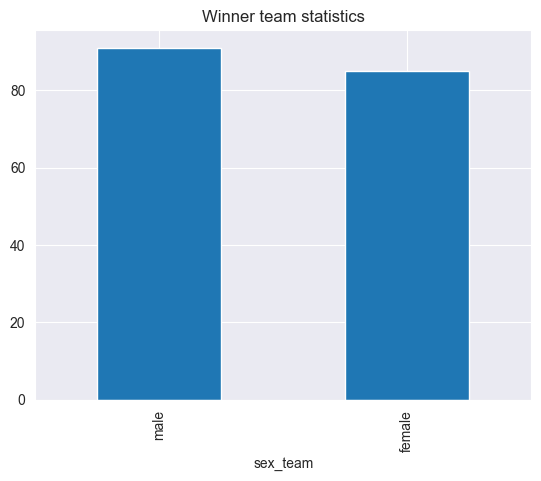

In [36]:
# Winner team statistics
winners = df['sex_team'].value_counts()
winners = winners.rename(index={0: 'female', 1: 'male'})
winners.plot(kind='bar', title='Winner team statistics')

<Axes: title={'center': 'Age statistics'}, ylabel='Frequency'>

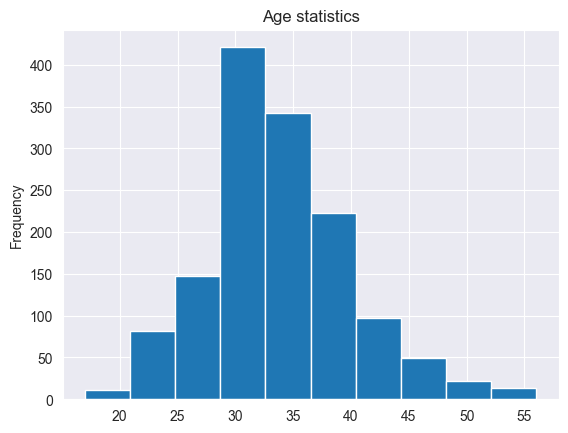

In [37]:
# Age statistics
age_columns = [col for col in df.columns if re.match(r'p\d_age|mc_age|fc_age', col)]
age_values = pd.concat([df[col] for col in age_columns])
age_values.plot(kind='hist', title='Age statistics')

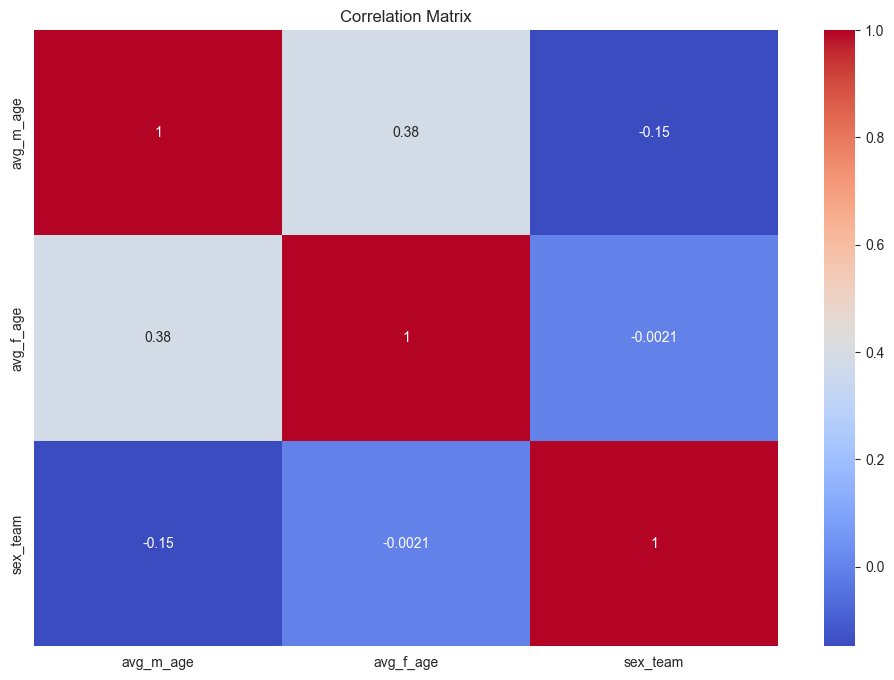

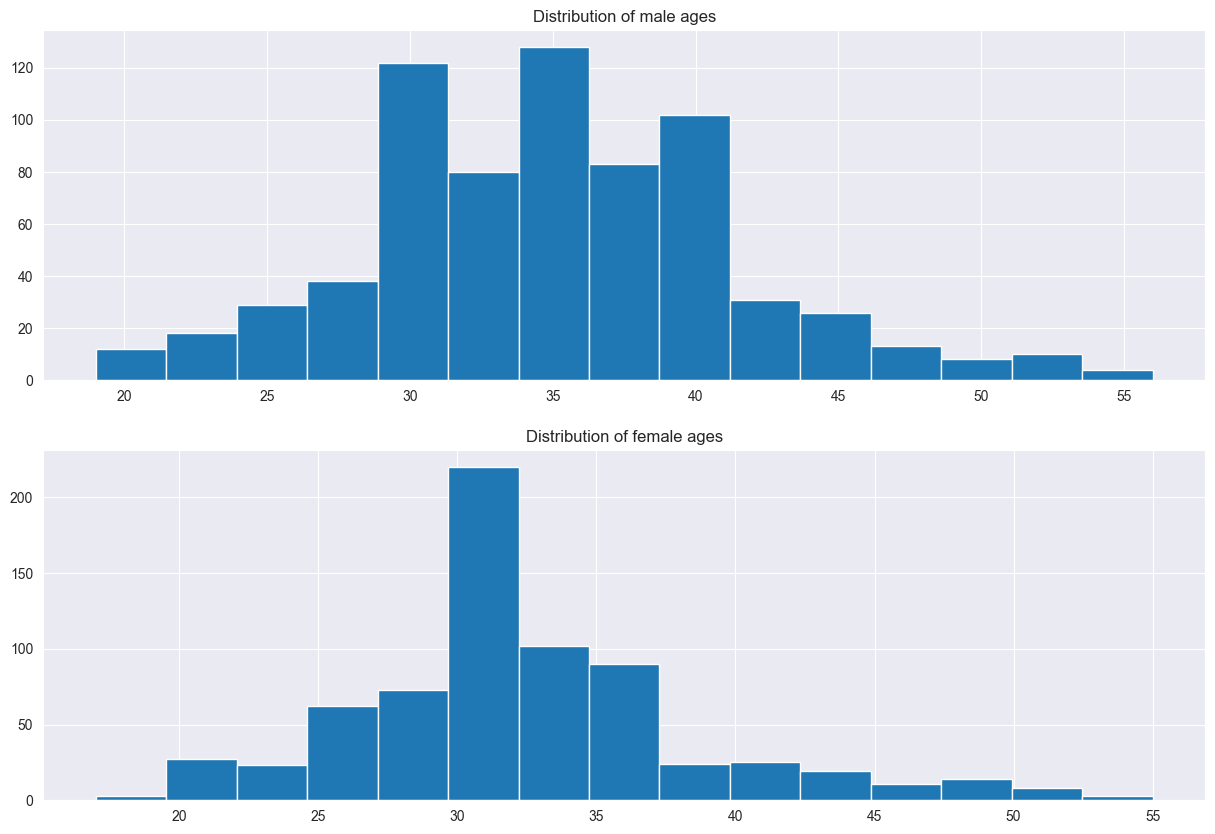

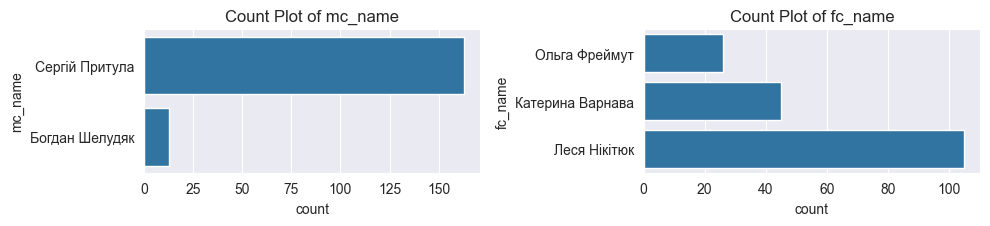

In [38]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
males_ages = ['p1_age', 'p2_age', 'p3_age', 'mc_age']
females_ages = ['p4_age', 'p5_age', 'p6_age', 'fc_age']
df['avg_m_age'] = df.loc[:, males_ages].mean(axis=1)
df['avg_f_age'] = df.loc[:, females_ages].mean(axis=1)
num_columns = ['avg_m_age', 'avg_f_age', 'sex_team']
numerical_features = df[num_columns]
correlation_matrix = numerical_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
df.drop(columns=['avg_m_age', 'avg_f_age'], inplace=True)

# Distribution of Numerical Features
males_ages = pd.concat([df[col] for col in males_ages])
females_ages = pd.concat([df[col] for col in females_ages])
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
males_ages.hist(bins=15)
plt.title('Distribution of male ages')
plt.subplot(2, 1, 2)
females_ages.hist(bins=15)
plt.title('Distribution of female ages')
plt.show()

# Count Plots for Categorical Features
categorical_features = ['mc_name', 'fc_name']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(5, 3, i)
    sns.countplot(y=df[col])
    plt.title(f'Count Plot of {col}')
plt.tight_layout()
plt.show()

In [39]:
# Encode the name columns
label_encoder = LabelEncoder()
label_encoder_classes = {}

# Define the columns to encode
name_columns = re.findall(r'p\d_name|mc_name|fc_name', ' '.join(df.columns))
combined_series = pd.concat([df[col] for col in name_columns])

label_encoder.fit(combined_series)

# Encode the columns
for col in name_columns:
    df[col] = label_encoder.transform(df[col])
    label_encoder_classes[col] = label_encoder.classes_
df.head()

,p1_name,p2_name,p3_name,mc_name,p4_name,p5_name,p6_name,fc_name,p1_sex,p2_sex,...,fc_sex,sex_team,p1_age,p2_age,p3_age,mc_age,p4_age,p5_age,p6_age,fc_age
0,160,148,96,378,425,426,280,341,1,1,...,0,1,27,32,35,30,29,22,31,30
1,293,416,307,378,343,73,164,341,1,1,...,0,0,38,41,38,30,26,28,29,30
2,316,199,134,378,339,270,334,341,1,1,...,0,0,22,34,29,30,33,21,21,30
3,369,417,124,378,132,162,60,341,1,1,...,0,1,38,23,37,30,34,27,31,30
4,195,191,193,378,333,251,39,341,1,1,...,0,0,40,42,26,30,24,21,28,30


In [40]:
# Define the target variable
Y = df['sex_team']
X = df.drop(columns=['sex_team'])

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140, 24), (36, 24), (140,), (36,))

In [42]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [43]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 1.0, 1: 1.0}

In [44]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
# Build the model
model1 = Sequential()
model1.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(4, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# Train the model
model1.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
15/15 [==============================] - 1s 1ms/step - loss: 0.7113 - accuracy: 0.4863
Epoch 2/100
15/15 [==============================] - 0s 1ms/step - loss: 0.7049 - accuracy: 0.5000
Epoch 3/100
15/15 [==============================] - 0s 970us/step - loss: 0.7001 - accuracy: 0.5068
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6964 - accuracy: 0.5068
Epoch 5/100
15/15 [==============================] - 0s 974us/step - loss: 0.6929 - accuracy: 0.5137
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6896 - accuracy: 0.5274
Epoch 7/100
15/15 [==============================] - 0s 929us/step - loss: 0.6871 - accuracy: 0.5274
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.5274
Epoch 9/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6826 - accuracy: 0.5342
Epoch 10/100
15/15 [==============================] - 0s 975us/step - loss: 0.6809 - accuracy: 0.5342
E

In [47]:
# Evaluate the model
_, accuracy = model1.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy * 100))

2/2 [==============================] - 0s 3ms/step - loss: 1.0672 - accuracy: 0.3889
Accuracy: 38.89


In [48]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0]
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = []
model2 = None
for lr in learning_rates:
    for dropout in dropouts:
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, class_weight=class_weights, verbose=0,
                  callbacks=[early_stopping])
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        if model2 is None or accuracy > max(accuracies):
            model2 = model
        accuracies.append(accuracy)

for lr, i in zip(learning_rates, range(len(learning_rates))):
    for dropout, j in zip(dropouts, range(len(dropouts))):
        print(f'Learning rate: {lr}, Dropout: {dropout}, Accuracy: {accuracies[i * len(dropouts) + j]}')
best_accuracy = max(accuracies)
lr = learning_rates[accuracies.index(best_accuracy) // len(dropouts)]
dropout = dropouts[accuracies.index(best_accuracy) % len(dropouts)]
print(f'Best accuracy: {best_accuracy}, Best learning rate: {lr}, Best dropout: {dropout}')

Learning rate: 0.01, Dropout: 0.1, Accuracy: 0.4722222089767456
Learning rate: 0.01, Dropout: 0.2, Accuracy: 0.5277777910232544
Learning rate: 0.01, Dropout: 0.3, Accuracy: 0.5277777910232544
Learning rate: 0.01, Dropout: 0.4, Accuracy: 0.5
Learning rate: 0.01, Dropout: 0.5, Accuracy: 0.5833333134651184
Learning rate: 0.001, Dropout: 0.1, Accuracy: 0.5
Learning rate: 0.001, Dropout: 0.2, Accuracy: 0.5
Learning rate: 0.001, Dropout: 0.3, Accuracy: 0.5555555820465088
Learning rate: 0.001, Dropout: 0.4, Accuracy: 0.5555555820465088
Learning rate: 0.001, Dropout: 0.5, Accuracy: 0.5277777910232544
Learning rate: 0.0001, Dropout: 0.1, Accuracy: 0.4722222089767456
Learning rate: 0.0001, Dropout: 0.2, Accuracy: 0.5
Learning rate: 0.0001, Dropout: 0.3, Accuracy: 0.4722222089767456
Learning rate: 0.0001, Dropout: 0.4, Accuracy: 0.5555555820465088
Learning rate: 0.0001, Dropout: 0.5, Accuracy: 0.4722222089767456
Learning rate: 1e-05, Dropout: 0.1, Accuracy: 0.5833333134651184
Learning rate: 1e-05

In [49]:
# Evaluate the model
_, accuracy = model2.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy * 100))

2/2 [==============================] - 0s 3ms/step - loss: 0.9218 - accuracy: 0.5833
Accuracy: 58.33


In [50]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.3888888888888889


In [51]:
# Make predictions
predictions = model2.predict(X_test)

2/2 [==============================] - 0s 3ms/step


In [52]:
# Test the model
test_data = X_test[0].reshape(1, -1)
prediction = model2.predict(test_data)
test_data = scaler.inverse_transform(test_data)
names_indexes = test_data[0][:8]
names = []
le = LabelEncoder()
for col in name_columns:
    le.classes_ = label_encoder_classes[col]
    names = le.inverse_transform([int(name) for name in names_indexes])
males = names[:4]
females = names[4:]
male_team = ', '.join(males)
female_team = ', '.join(females)
winner = 'female' if prediction < 0.5 else 'male'
print(f'Prediction: with male team: {male_team} and female team: {female_team}; the winner will be: {winner}')

1/1 [==============================] - 0s 16ms/step
Prediction: with male team: Григорій Решетник, Юрій Горбунов, Віталій Козловський, Сергій Притула and female team: Любов Юнак, Олена-Крістіна Лебідь, Олена Шоптенко, Ольга Фреймут; the winner will be: female
